In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
import seaborn as sns

ModuleNotFoundError: No module named 'sklearn'

In [2]:
sol = pd.read_excel("Husskonen_Solubility_Features.xlsx", engine='openpyxl', verbose=False)
print(sol.shape)
print(sol.columns[5:-1])
y = sol['LogS.M.']


(932, 2261)
Index(['MW', 'AMW', 'Sv', 'Se', 'Sp', 'Si', 'Mv', 'Me', 'Mp', 'Mi',
       ...
       'Depressant-50', 'Psychotic-80', 'Psychotic-50', 'Hypertens-80',
       'Hypertens-50', 'Hypnotic-80', 'Hypnotic-50', 'Neoplastic-80',
       'Neoplastic-50', 'Infective-80'],
      dtype='object', length=2255)


In [3]:
# compute pearson's r
target_correlation = sol.iloc[:,4:-1].corr()[['LogS.M.']]
# we only care about the target variable

In [1]:
# extract the most correlated features with the output variable
features = target_correlation[abs(target_correlation)>0.48].dropna()
plt.figure(figsize=(300,300))
sns.heatmap(features, annot=False, cmap=plt.cm.Reds)
plt.show()

NameError: name 'target_correlation' is not defined

In [5]:
indexes = features.iloc[1:,:].index.values
print(indexes.shape)

(547,)


In [6]:
X_features = sol[indexes]
print(X_features)

         MW      Sp     Mv     Mp     Mi  nBO  nBM  SCBO  nC  nCL  ...  \
0    180.22  16.296  0.710  0.741  1.102   16   16  24.0  12    0  ...   
1    146.17  11.784  0.683  0.693  1.142   12   11  17.5   7    0  ...   
2    146.17  11.784  0.683  0.693  1.142   12   11  17.5   7    0  ...   
3    146.17  11.784  0.683  0.693  1.142   12   11  17.5   7    0  ...   
4    162.17  12.239  0.685  0.680  1.145   13   11  18.5   7    0  ...   
..      ...     ...    ...    ...    ...  ...  ...   ...  ..  ...  ...   
927  188.25  17.273  0.630  0.664  1.126   15    8  20.0  11    0  ...   
928  215.72  17.693  0.592  0.632  1.161   14    6  17.0   8    1  ...   
929  232.26  19.182  0.649  0.661  1.128   18    9  24.0  12    0  ...   
930  233.11  16.989  0.669  0.708  1.132   14    7  18.0   9    2  ...   
931  238.18  15.057  0.704  0.655  1.150   18   10  25.5   8    0  ...   

     ALOGP2       Vx   VvdwMG  VvdwZAZ    PDI  BLTF96  BLTD48  BLTA96  DLS_01  \
0     4.851  227.940   96.795 

In [7]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X_features)
X_scaled = pd.DataFrame(data = X_scaled, columns = X_features.columns)
X_train, X_test, y_train, y_test = train_test_split(X_scaled.to_numpy(), y.to_numpy(), test_size=0.2)

In [8]:
def regmodel_param_plot(
    validation_score, train_score, alphas_to_try, chosen_alpha,
    scoring, model_name, test_score = None, filename = None):

    plt.figure(figsize = (8,8))
    sns.lineplot(y = validation_score, x = alphas_to_try,
                 label = 'validation_data')
    sns.lineplot(y = train_score, x = alphas_to_try,
                 label = 'training_data')
    plt.axvline(x=chosen_alpha, linestyle='--')
    if test_score is not None:
        sns.lineplot(y = test_score, x = alphas_to_try,
                     label = 'test_data')
    plt.xlabel('alpha_parameter')
    plt.ylabel(scoring)
    plt.title(model_name + ' Regularisation')
    plt.legend()
    if filename is not None:
        plt.savefig(str(filename) + ".png")
    plt.show()

In [29]:
from sklearn.model_selection import cross_validate, RepeatedKFold
from sklearn.metrics import get_scorer

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

def regmodel_param_test(
    alphas_to_try, X, y, cv, scoring = 'r2',
    model_name = 'LASSO', X_test = None, y_test = None,
    draw_plot = False, filename = None):

    validation_scores = []
    train_scores = []
    results_list = []
    if X_test is not None:
        test_scores = []
        scorer = get_scorer(scoring)
    else:
        test_scores = None

    for curr_alpha in alphas_to_try:

        if model_name == 'LASSO':
            regmodel = Lasso(alpha = curr_alpha, tol=0.1)
        elif model_name == 'Ridge':
            regmodel = Ridge(alpha = curr_alpha)
        else:
            return None

        results = cross_validate(
            regmodel, X, y, scoring=scoring, cv=cv,
            return_train_score = True)

        validation_scores.append(np.mean(results['test_score']))
        train_scores.append(np.mean(results['train_score']))
        results_list.append(results)

        if X_test is not None:
            regmodel.fit(X,y)
            y_pred = regmodel.predict(X_test)
            test_scores.append(scorer(regmodel, X_test, y_test))

    chosen_alpha_id = np.argmax(validation_scores)
    chosen_alpha = alphas_to_try[chosen_alpha_id]
    max_validation_score = np.max(validation_scores)
    if X_test is not None:
        test_score_at_chosen_alpha = test_scores[chosen_alpha_id]
    else:
        test_score_at_chosen_alpha = None

    if draw_plot:
        regmodel_param_plot(
            validation_scores, train_scores, alphas_to_try, chosen_alpha,
            scoring, model_name, test_scores, filename)

    return chosen_alpha, max_validation_score, test_score_at_chosen_alpha

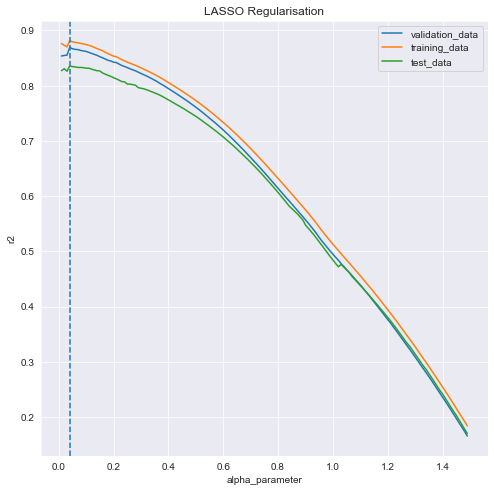

Chosen alpha: 0.04000
Validation score: 0.86923
Test score at chosen alpha: 0.83574


In [30]:
chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test(
        np.arange(0.01,1.5,0.01), X_train, y_train,
        cv, scoring = 'r2', model_name = 'LASSO',
        X_test = X_test, y_test = y_test,
        draw_plot = True, filename = 'lasso_wide_search')
print("Chosen alpha: %.5f" % \
    chosen_alpha)
print("Validation score: %.5f" % \
    max_validation_score)
print("Test score at chosen alpha: %.5f" % \
    test_score_at_chosen_alpha)

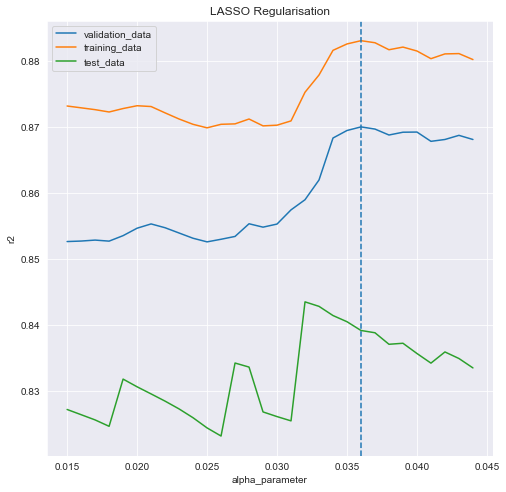

Chosen alpha: 0.03600
Validation score: 0.87002
Test score at chosen alpha: 0.83922


In [31]:
chosen_alpha, max_validation_score, test_score_at_chosen_alpha = \
    regmodel_param_test(
        np.arange(0.015,0.045,0.001), X_train, y_train,
        cv, scoring = 'r2', model_name = 'LASSO',
        X_test = X_test, y_test = y_test,
        draw_plot = True, filename = 'lasso_wide_search')
print("Chosen alpha: %.5f" % \
    chosen_alpha)
print("Validation score: %.5f" % \
    max_validation_score)
print("Test score at chosen alpha: %.5f" % \
    test_score_at_chosen_alpha)

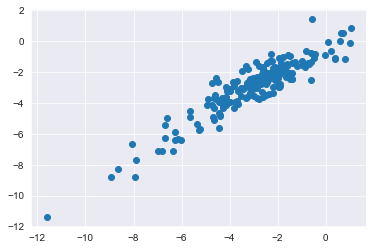

0.5792453006539143


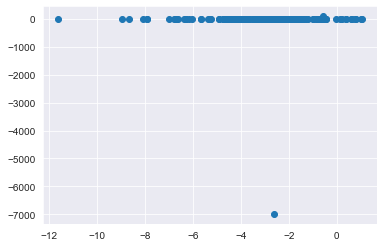

261165.24183252797


In [37]:
from sklearn.linear_model import LinearRegression

las = linear_model.Lasso(alpha=0.035)
las.fit(X_train,y_train)
lasPred = las.predict(X_test)
plt.scatter(y_test,lasPred)
plt.show()
print(mean_squared_error(y_test,lasPred))

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
predictions = lin_reg.predict(X_test)
plt.scatter(y_test, predictions)
plt.show()
print(mean_squared_error(y_test,predictions))

In [36]:
from sklearn.feature_selection import RFECV
lin_reg = Lasso(alpha=0.035,tol=0.1)
rfecv = RFECV(estimator=lin_reg, scoring='neg_mean_squared_error')
rfecv.fit(X_features, y)
rfecv.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True, False,  True, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
        True,  True,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False,  True, False, False, False,
       False, False,

In [20]:
#filtered_arr = [p for p in rfecv.support_ if p == True]